In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import tarfile
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir ="flowers"
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
    ]
)
database = ImageFolder(data_dir, transform=transformer)

In [3]:
database.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [4]:
flower_name_dict={'daisy':0 ,
                  'dandelion':1,
                  'rose':2 ,
                  'sunflower':3 ,
                  'tulip':4}

def encode_label(img_label):
    return flower_name_dict[img_label] 

In [5]:
flower_label = {
    0: 'daisy',
    1: 'dandelion',
    2: 'rose',
    3: 'sunflower',
    4: 'tulip'
}

In [6]:
def show_batch(dl,invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

def show_sample(image, label,invert=True):
    print("Label :" +database.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Label :daisy(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


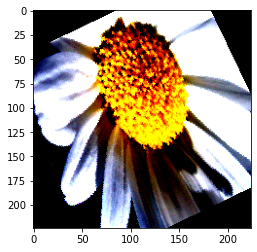

In [7]:
show_sample(*database[1])

In [8]:
validation_size = 500
training_size = len(database) - validation_size

In [9]:
train_ds, val_ds_main = random_split(database,[training_size, validation_size])
val_ds, test_ds  = random_split(val_ds_main,[300, 200])
len(train_ds), len(val_ds)

(3817, 300)

In [10]:
batch_size=32

In [11]:
train_dl = DataLoader(train_ds, batch_size , shuffle=True)
val_dl = DataLoader(val_ds,batch_size)
test_dl = DataLoader(test_ds, batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


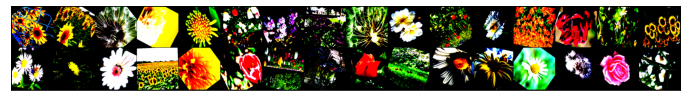

In [12]:
show_batch(train_dl,invert=True)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FlowerClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
class FlowerModel18(FlowerClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.shufflenet_v2_x1_0(pretrained=True)
        # Replace last layer
        #num_ftrs = self.network.fc.in_features
        #self.network.fc = nn.Linear(num_ftrs, 5)
#        for param in self.network.parameters():
#            param.requires_grad = True
#
#        self.network.fc = nn.Linear(512, 5)
# check line 141 at https://github.com/pytorch/vision/blob/main/torchvision/models/shufflenetv2.py
#
        output_channels = self.network._stage_out_channels[-1]
        self.network.fc = nn.Linear(output_channels, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
model = FlowerModel18()
model

FlowerModel18(
  (network): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): Batc

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def train(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);



In [18]:
model = to_device(FlowerModel18(), device)
evaluate(model, val_dl)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001


In [19]:
try1 = train(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.2346, val_loss: 1.0857, val_acc: 0.8188
Epoch [1], train_loss: 1.0663, val_loss: 1.0611, val_acc: 0.8469
Epoch [2], train_loss: 1.0327, val_loss: 1.0438, val_acc: 0.8458
Epoch [3], train_loss: 1.0259, val_loss: 1.0312, val_acc: 0.8552
Epoch [4], train_loss: 1.0150, val_loss: 1.0249, val_acc: 0.8646
Epoch [5], train_loss: 1.0047, val_loss: 1.0178, val_acc: 0.8687
Epoch [6], train_loss: 1.0001, val_loss: 1.0266, val_acc: 0.8625
Epoch [7], train_loss: 0.9973, val_loss: 1.0278, val_acc: 0.8771
Epoch [8], train_loss: 1.0012, val_loss: 1.0186, val_acc: 0.8844
Epoch [9], train_loss: 0.9927, val_loss: 1.0087, val_acc: 0.8813


In [20]:
torch.save(model.state_dict(), 'flower_pretrains2_gpu.pth')

In [21]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    print(yb)
    return flower_label[preds[0].item()]

tensor([[0.4953, 0.5030, 0.4978, 0.4976, 0.4998]], grad_fn=<SigmoidBackward>)
Label: rose , Predicted: dandelion


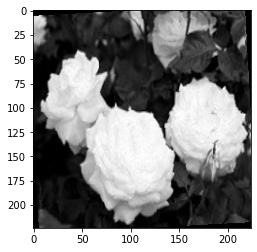

In [22]:
img, label = test_ds[1]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))


tensor([[0.4941, 0.4959, 0.5040, 0.4930, 0.5008]], grad_fn=<SigmoidBackward>)
Label: sunflower , Predicted: rose


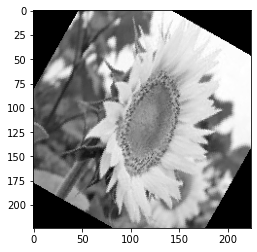

In [23]:
img, label = test_ds[11]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))

In [24]:
print(label)

3


tensor([[0.4942, 0.4945, 0.5039, 0.4942, 0.4954]], grad_fn=<SigmoidBackward>)
Label: sunflower , Predicted: rose


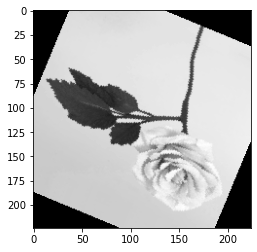

In [26]:
from PIL import Image
from torchvision import transforms

img_cat = Image.open("p1.jpeg").convert('RGB')

img = transformer(img_cat)

plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, FlowerModel18()))